In [1]:
import torch
import torch.nn as nn
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, ToPILImage
import torch.nn.functional as F

import time
import copy
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
import os
# os.environ['http_proxy'] = "" 
# os.environ['https_proxy'] = ""
device_id = 0
torch.cuda.set_device('cuda:%d' % device_id)

In [3]:
from diffusers.pipelines.stable_diffusion import StableDiffusionPipeline
from piecewise_rectified_flow.src.scheduler_perflow import PeRFlowScheduler

pipe = StableDiffusionPipeline.from_pretrained("/root/wuyujia_proj/RectifID/models/perflow-sd15-dreamshaper", safety_checker=None, torch_dtype=torch.float16, local_file_only = True)
# pipe = StableDiffusionPipeline.from_pretrained("hansyan/perflow-sd15-realisticVisionV51", safety_checker=None, torch_dtype=torch.float16)
# pipe = StableDiffusionPipeline.from_pretrained("hansyan/perflow-sd15-disney", safety_checker=None, torch_dtype=torch.float16)
pipe.scheduler = PeRFlowScheduler.from_config(pipe.scheduler.config, prediction_type="diff_eps", num_time_windows=4)

/root/anaconda3/envs/perflow/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-23 14:42:40.348513: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 14:42:40.405848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 14:42:40.405882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 14:42:40.407525: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cu

In [4]:
for module in [pipe.vae, pipe.text_encoder, pipe.unet]:
    for param in module.parameters():
        param.requires_grad = False

pipe.to("cuda")
pipe.set_progress_bar_config(disable=True)

my_forward = pipe.__call__.__wrapped__

In [5]:
import insightface
from onnx2torch import convert

# antelopev2
# https://github.com/deepinsight/insightface/tree/master/python-package#model-zoo
detector = insightface.model_zoo.get_model('/root/wuyujia_proj/RectifID/models/antelopev2/scrfd_10g_bnkps.onnx', provider_options=[{'device_id': device_id}, {}])
detector.prepare(ctx_id=0, input_size=(640, 640))
model = convert('/root/wuyujia_proj/RectifID/models/antelopev2/glintr100.onnx').eval().to('cuda')
for param in model.parameters():
    param.requires_grad_(False)

2024-10-23 14:42:46.407115613 [E:onnxruntime:Default, provider_bridge_ort.cc:1992 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1637 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.12: cannot open shared object file: No such file or directory

2024-10-23 14:42:46.407148263 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:965 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned in the GPU requirements page (https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements), make sure they're in the PATH, and that your GPU is supported.


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


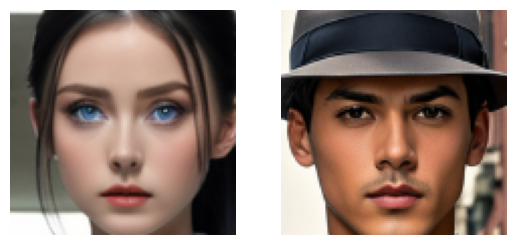

In [6]:
from PIL import Image
import torchvision.transforms.functional as TF
import kornia


ref1 = '/root/wuyujia_proj/RectifID/character_image/character_2.png'
# ref1 = 'assets/bengio.jpg'
# ref1 = 'assets/schmidhuber.jpg'
# ref1 = 'assets/johansson.jpg'
# ref1 = 'assets/newton.jpg'
# ref2 = 'assets/hinton.jpg'
ref2 = '/root/wuyujia_proj/RectifID/character_image/character_4.png'
# ref2 = 'assets/schmidhuber.jpg'
# ref2 = 'assets/johansson.jpg'
# ref2 = 'assets/newton.jpg'

ref_image1 = Image.open(ref1).convert("RGB")
ref_image2 = Image.open(ref2).convert("RGB")

def crop_image_embed(ref_image):
    with torch.no_grad():
        det_thresh_backup = detector.det_thresh
        boxes = []
        while len(boxes) == 0:
            boxes, kpss = detector.detect(np.array(ref_image), max_num=1)
            detector.det_thresh -= 0.1
        detector.det_thresh = det_thresh_backup
        M = insightface.utils.face_align.estimate_norm(kpss[0])
        ref_image_cropped = kornia.geometry.transform.warp_affine(
            TF.to_tensor(ref_image).unsqueeze(0).to('cuda'), torch.tensor(M).float().unsqueeze(0).to('cuda'), (112, 112)
        ) * 2 - 1

        ref_embedding = model(ref_image_cropped)
    return ref_image_cropped, ref_embedding

ref_image_cropped1, ref_embedding1 = crop_image_embed(ref_image1)
ref_image_cropped2, ref_embedding2 = crop_image_embed(ref_image2)

cropped_image1 = np.array((ref_image_cropped1[0] / 2 + 0.5).cpu().permute(1, 2, 0) * 255, dtype=np.uint8)
cropped_image2 = np.array((ref_image_cropped2[0] / 2 + 0.5).cpu().permute(1, 2, 0) * 255, dtype=np.uint8)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(cropped_image1)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cropped_image2)
plt.axis("off")
plt.show()

In [7]:
import tensorflow as tf
from deepface import DeepFace

tf.config.set_visible_devices([], device_type='GPU')
attribute1 = DeepFace.analyze(img_path=ref1, actions = ['gender', 'race'])
attribute2 = DeepFace.analyze(img_path=ref2, actions = ['gender', 'race'])
print(attribute1)
print(attribute2)

2024-10-23 14:42:52.880927: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Action: race: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]  

[{'gender': {'Woman': 3.318522125482559, 'Man': 96.68147563934326}, 'dominant_gender': 'Man', 'region': {'x': 358, 'y': 1179, 'w': 54, 'h': 54, 'left_eye': None, 'right_eye': None}, 'face_confidence': 0.98, 'race': {'asian': 0.08087306832731446, 'indian': 0.030685096115160453, 'black': 0.008960651417064125, 'white': 97.4894705427324, 'middle eastern': 0.8794722961518412, 'latino hispanic': 1.510533976044181}, 'dominant_race': 'white'}, {'gender': {'Woman': 99.5682954788208, 'Man': 0.43170545250177383}, 'dominant_gender': 'Woman', 'region': {'x': 331, 'y': 51, 'w': 114, 'h': 114, 'left_eye': (364, 96), 'right_eye': (408, 97)}, 'face_confidence': 0.9, 'race': {'asian': 0.07433700236265375, 'indian': 0.01662612002256483, 'black': 0.0015031731877679323, 'white': 93.78184043060782, 'middle eastern': 2.344987681209307, 'latino hispanic': 3.7807038444700147}, 'dominant_race': 'white'}]
[{'gender': {'Woman': 13.182619214057922, 'Man': 86.81738376617432}, 'dominant_gender': 'Man', 'region': {'x

In [8]:
idx1 = np.argmax([a['region']['w'] * a['region']['h'] for a in attribute1])
print(attribute1[idx1]['dominant_gender'], attribute1[idx1]['dominant_race'])

idx2 = np.argmax([a['region']['w'] * a['region']['h'] for a in attribute2])
print(attribute2[idx2]['dominant_gender'], attribute2[idx2]['dominant_race'])

Woman white
Man latino hispanic


In [16]:
from diffusers.utils.torch_utils import randn_tensor

generator = torch.manual_seed(42)

latents = nn.Parameter(randn_tensor((4, 4, 64, 64), generator=generator, device=pipe._execution_device, dtype=pipe.text_encoder.dtype))
latents0 = latents.data[:1].clone()
optimizer = torch.optim.SGD([latents], 1)  # 1 or 2

torch.float16


In [10]:
# prompt = 'A person and a person in the snow'
# prompt = 'a movie poster of a person and a person'
prompt = "Close-up photo of the happy smiles on the faces of the cool person and beautiful person as they leave the island with the treasure, sail back to the vacation beach, and begin their love story, 35mm photograph, film, professional, 4k, highly detailed."
# prompt = "A person and a person on the beach"
# prompt = "A person and a person sitting in a park"
# prompt = "A person and a person holding a bottle of red wine"
# prompt = "A person and a person standing together"
# prompt = "A person and a person riding a horse"

if attribute1[idx1]['dominant_gender'] == 'Man':
    prompt = prompt.replace('person', attribute1[idx1]['dominant_race'] + ' man', 1)
else:
    prompt = prompt.replace('person', attribute1[idx1]['dominant_race'] + ' woman', 1)

if attribute2[idx2]['dominant_gender'] == 'Man':
    prompt = prompt.replace('person', attribute2[idx2]['dominant_race'] + ' man', 1)
else:
    prompt = prompt.replace('person', attribute2[idx2]['dominant_race'] + ' woman', 1)
prompt = prompt
# prompt = prompt + ', faces'

In [11]:
import clip
from torchvision import transforms
from torchvision.transforms import functional as FT
from torchvision.transforms.functional import InterpolationMode   
def text2img_similarity(model, image, caption, device='cuda'):

    image = image.unsqueeze(0).to(device) 

    # image = F.interpolate(image, size=224, mode='bicubic', align_corners=False).squeeze(0)
    # _, h, w = image.shape
    # top = (h - 224) // 2
    # left = (w - 224) // 2
    # image = image[:, top:top + 224, left:left + 224]
    # image = image.unsqueeze(0)
    image = FT.resize(image, size=224, interpolation=InterpolationMode.BICUBIC, max_size=None, antialias='warn')
    image = FT.center_crop(image, (224, 224))
    image = image + torch.randn_like(image) * 0.005
    
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1, 3, 1, 1).to(device)
    image = (image - mean) / std


    text_tokens = clip.tokenize([caption]).to(device)

    logits_per_image, logits_per_text = model(image, text_tokens)

    return logits_per_image[0][0]

clip_model, clip_processor = clip.load("ViT-B/32", device='cuda')


In [12]:
from segment_anything import build_sam, SamPredictor
from groundingdino.util.inference import load_model, load_image, predict
from torchvision.ops import box_convert

def person_detector(model,
                    image,
                    box_threshold,
                    text_threshold):
    image_source, image = load_image(image)

    detected_obj = []
    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption='person',
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )
    h, w, _ = image_source.shape
    boxes = boxes * torch.tensor([w, h, w, h])
    boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    if len(boxes) > 0:
        boxes = [list(map(int, box)) for box in boxes]
        detected_obj.extend(boxes)
    return detected_obj

def process_image(image, device):
    image = image.unsqueeze(0).to(device) 
    
    image = FT.resize(image, size=224, interpolation=InterpolationMode.BICUBIC, max_size=None, antialias='warn')
    # image = kornia.geometry.transform.resize(image, (224, 224), interpolation='bicubic', align_corners=False)
    # print("after bubic",image)
    # print(image.shape)

    image = FT.center_crop(image, (224, 224))
    image = image + torch.randn_like(image) * 0.01
    # _, h, w = image.shape
    # top = (h - 224) // 2
    # left = (w - 224) // 2
    # image = image[:, top:top + 224, left:left + 224]
    # image = image.unsqueeze(0)
    # print("after center crop",image)
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1, 3, 1, 1).to(device)
    image = (image - mean) / std
    return image

def char2char_similarity(dino_model,
                         clip_model,
                         sam_predictor,
                         processor,
                         generate_image_np,
                         generate_image,
                         character_image_list,
                         character_image_list_np,
                         device,
                         box_threshold=0.5,
                         text_threshold=0.25):
    output_similarity = 0
    person_boxes = person_detector(
        dino_model, generate_image_np, box_threshold, text_threshold)
    person_image_list = []
    for person_box in person_boxes:
        xmin, ymin, xmax, ymax = person_box
        person_image =  generate_image[:, ymin:ymax, xmin:xmax]
        person_image_list.append(person_image)
 
    character_similarity_list = []
    for character_image, character_image_np in zip(character_image_list, character_image_list_np):
        person_box = person_detector(
            dino_model, character_image_np, box_threshold, text_threshold)[0]
        xmin, ymin, xmax, ymax = person_box
        # print(person_box)
   
        character_image = character_image[:, ymin:ymax, xmin:xmax]
        # print("input",character_image)
        # print("input shape",character_image.shape)
        character_input = process_image(character_image, device)
        # print("output",character_input)
        # character_input = processor(character_image).unsqueeze(0).to(device)
        character_similarity = 0

        # with torch.no_grad():
        character_features = clip_model.encode_image(character_input)
        for person_image in person_image_list:
            # person_input = processor(person_image).unsqueeze(0).to(device)
            person_input = process_image(person_image, device)
            # print(person_input)
            person_features = clip_model.encode_image(person_input)
            cos = torch.nn.CosineSimilarity(dim=0)
            similarity = cos(character_features[0], person_features[0])
            if similarity > character_similarity:
                character_similarity = similarity
        character_similarity_list.append(character_similarity)
        output_similarity += character_similarity
    output_similarity = output_similarity / len(character_image_list)
    return output_similarity

dino_model = load_model(
            "/root/wuyujia_proj/RectifID/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py",
            "/root/wuyujia_proj/RectifID/GroundingDINO/weights/groundingdino_swint_ogc.pth")
sam = build_sam(
    checkpoint='/root/wuyujia_proj/RectifID/models/sam/sam_vit_h_4b8939.pth')
sam_predictor = SamPredictor(sam)

character_image_list = [torch.tensor(np.array(ref_image1), dtype=torch.float32).permute(2, 0, 1).to(torch.device('cuda')) / 255.0, torch.tensor(np.array(ref_image2), dtype=torch.float32).permute(2, 0, 1).to(torch.device('cuda')) / 255.0]

character_image_list_np = [np.array(ref_image1), np.array(ref_image2)]

final text_encoder_type: bert-base-uncased


  0%|          | 0/61 [00:00<?, ?it/s]

t2i_similarity: 30.140625
character_similarity: 0.5712890625
face1 similarity: 0.060565635561943054
face2 similarity: 0.04499565809965134
loss: 816.81884765625
grad: [3226.0, 721.0, 162.125, 72.0]
time: 0.2721364498138428 0.15372228622436523 (0.500000) 0.6219232082366943 1.026984453201294 0.0004100799560546875


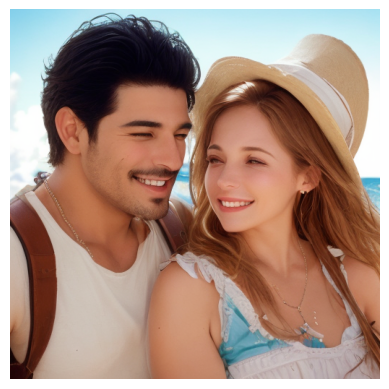

  2%|▏         | 1/61 [00:02<02:28,  2.48s/it]

t2i_similarity: 31.234375
character_similarity: 0.58544921875
face1 similarity: 0.16942638158798218
face2 similarity: 0.17739588022232056


  3%|▎         | 2/61 [00:04<02:21,  2.40s/it]

t2i_similarity: 34.25
character_similarity: 0.58203125
face1 similarity: 0.18227465450763702
face2 similarity: 0.2704370319843292


  5%|▍         | 3/61 [00:07<02:17,  2.37s/it]

t2i_similarity: 34.65625
character_similarity: 0.60546875
face1 similarity: 0.2210317850112915
face2 similarity: 0.3095009922981262


  7%|▋         | 4/61 [00:09<02:13,  2.34s/it]

t2i_similarity: 36.34375
character_similarity: 0.6064453125
face1 similarity: 0.2239009439945221
face2 similarity: 0.3279203772544861


  8%|▊         | 5/61 [00:11<02:10,  2.33s/it]

t2i_similarity: 37.3125
character_similarity: 0.6337890625
face1 similarity: 0.4181554913520813
face2 similarity: 0.2556925415992737


 10%|▉         | 6/61 [00:14<02:07,  2.31s/it]

t2i_similarity: 36.59375
character_similarity: 0.6259765625
face1 similarity: 0.2788904309272766
face2 similarity: 0.491072416305542


 11%|█▏        | 7/61 [00:16<02:05,  2.32s/it]

t2i_similarity: 36.78125
character_similarity: 0.6328125
face1 similarity: 0.2967097759246826
face2 similarity: 0.30125075578689575


 13%|█▎        | 8/61 [00:18<02:02,  2.31s/it]

t2i_similarity: 37.71875
character_similarity: 0.626953125
face1 similarity: 0.353096604347229
face2 similarity: 0.47339481115341187


 15%|█▍        | 9/61 [00:20<02:00,  2.31s/it]

t2i_similarity: 37.59375
character_similarity: 0.6396484375
face1 similarity: 0.532723069190979
face2 similarity: 0.35747724771499634


 16%|█▋        | 10/61 [00:23<01:58,  2.32s/it]

t2i_similarity: 39.15625
character_similarity: 0.6435546875
face1 similarity: 0.55855393409729
face2 similarity: 0.378711462020874
loss: 570.9609375
grad: [269.5, 161.125, 54.84375, 37.78125]
time: 0.2552621364593506 0.12363719940185547 (0.500000) 0.6245930194854736 1.0343883037567139 0.0019254684448242188


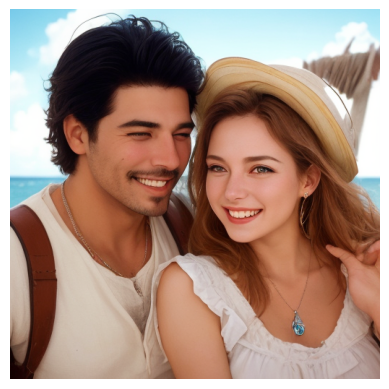

 18%|█▊        | 11/61 [00:25<01:58,  2.38s/it]

t2i_similarity: 39.625
character_similarity: 0.6513671875
face1 similarity: 0.42338019609451294
face2 similarity: 0.6066733002662659


 20%|█▉        | 12/61 [00:28<01:55,  2.35s/it]

t2i_similarity: 36.875
character_similarity: 0.66064453125
face1 similarity: 0.4492032527923584
face2 similarity: 0.6028294563293457


 21%|██▏       | 13/61 [00:30<01:52,  2.34s/it]

t2i_similarity: 38.125
character_similarity: 0.65185546875
face1 similarity: 0.434894859790802
face2 similarity: 0.6518291234970093


 23%|██▎       | 14/61 [00:32<01:49,  2.33s/it]

t2i_similarity: 39.75
character_similarity: 0.64697265625
face1 similarity: 0.4507353603839874
face2 similarity: 0.64719557762146


 25%|██▍       | 15/61 [00:35<01:46,  2.32s/it]

t2i_similarity: 40.09375
character_similarity: 0.666015625
face1 similarity: 0.4819168150424957
face2 similarity: 0.5680227875709534


 26%|██▌       | 16/61 [00:37<01:44,  2.33s/it]

t2i_similarity: 40.71875
character_similarity: 0.6748046875
face1 similarity: 0.5256723761558533
face2 similarity: 0.6951169967651367


 28%|██▊       | 17/61 [00:39<01:42,  2.33s/it]

t2i_similarity: 40.78125
character_similarity: 0.66796875
face1 similarity: 0.4795922636985779
face2 similarity: 0.6802772283554077


 30%|██▉       | 18/61 [00:42<01:40,  2.33s/it]

t2i_similarity: 41.8125
character_similarity: 0.67578125
face1 similarity: 0.5024981498718262
face2 similarity: 0.7266455888748169


 31%|███       | 19/61 [00:44<01:37,  2.33s/it]

t2i_similarity: 39.90625
character_similarity: 0.689453125
face1 similarity: 0.5148499608039856
face2 similarity: 0.7377391457557678


 33%|███▎      | 20/61 [00:46<01:35,  2.34s/it]

t2i_similarity: 41.1875
character_similarity: 0.68994140625
face1 similarity: 0.3879864513874054
face2 similarity: 0.7442523241043091
loss: 484.901123046875
grad: [158.625, 114.625, 67.25, 52.8125]
time: 0.2574648857116699 0.12426590919494629 (0.500000) 0.6324796676635742 1.0164005756378174 0.0021278858184814453


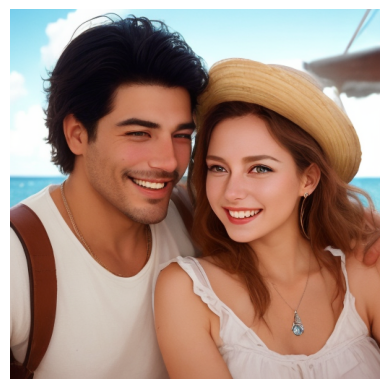

 34%|███▍      | 21/61 [00:49<01:35,  2.38s/it]

t2i_similarity: 39.78125
character_similarity: 0.68505859375
face1 similarity: 0.5212885141372681
face2 similarity: 0.7075387239456177


 36%|███▌      | 22/61 [00:51<01:32,  2.37s/it]

t2i_similarity: 42.1875
character_similarity: 0.6923828125
face1 similarity: 0.5595018267631531
face2 similarity: 0.7566214799880981


 38%|███▊      | 23/61 [00:53<01:29,  2.36s/it]

t2i_similarity: 42.03125
character_similarity: 0.70703125
face1 similarity: 0.5534758567810059
face2 similarity: 0.786697506904602


 39%|███▉      | 24/61 [00:56<01:27,  2.36s/it]

t2i_similarity: 42.0625
character_similarity: 0.705078125
face1 similarity: 0.5772402286529541
face2 similarity: 0.7646650075912476


 41%|████      | 25/61 [00:58<01:24,  2.36s/it]

t2i_similarity: 42.40625
character_similarity: 0.72265625
face1 similarity: 0.5885231494903564
face2 similarity: 0.7990651726722717


 43%|████▎     | 26/61 [01:00<01:22,  2.35s/it]

t2i_similarity: 42.65625
character_similarity: 0.72119140625
face1 similarity: 0.5976714491844177
face2 similarity: 0.7899627685546875


 44%|████▍     | 27/61 [01:03<01:20,  2.36s/it]

t2i_similarity: 42.65625
character_similarity: 0.70751953125
face1 similarity: 0.5086296796798706
face2 similarity: 0.8020220398902893


 46%|████▌     | 28/61 [01:05<01:17,  2.36s/it]

t2i_similarity: 43.40625
character_similarity: 0.71923828125
face1 similarity: 0.6387988328933716
face2 similarity: 0.7864018678665161


 48%|████▊     | 29/61 [01:07<01:15,  2.35s/it]

t2i_similarity: 42.96875
character_similarity: 0.7353515625
face1 similarity: 0.6604543924331665
face2 similarity: 0.822072446346283


 49%|████▉     | 30/61 [01:10<01:12,  2.35s/it]

t2i_similarity: 43.9375
character_similarity: 0.71484375
face1 similarity: 0.6328985691070557
face2 similarity: 0.8215604424476624
loss: 400.1791076660156
grad: [116.625, 74.25, 34.8125, 28.1875]
time: 0.2599937915802002 0.12419319152832031 (0.500000) 0.6283199787139893 1.035963773727417 0.0021266937255859375


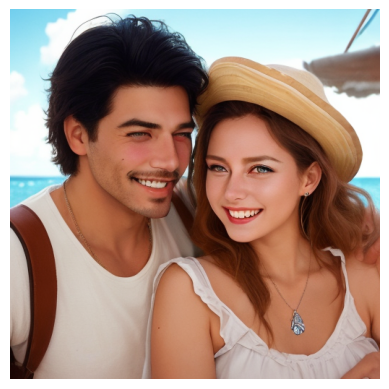

 51%|█████     | 31/61 [01:12<01:12,  2.40s/it]

t2i_similarity: 44.34375
character_similarity: 0.7109375
face1 similarity: 0.6648100018501282
face2 similarity: 0.8292593955993652


 52%|█████▏    | 32/61 [01:15<01:08,  2.38s/it]

t2i_similarity: 43.15625
character_similarity: 0.6728515625
face1 similarity: 0.6309692859649658
face2 similarity: 0.820906400680542


 54%|█████▍    | 33/61 [01:17<01:06,  2.36s/it]

t2i_similarity: 43.78125
character_similarity: 0.7001953125
face1 similarity: 0.6409690380096436
face2 similarity: 0.8443177342414856


 56%|█████▌    | 34/61 [01:19<01:03,  2.35s/it]

t2i_similarity: 45.09375
character_similarity: 0.740234375
face1 similarity: 0.6919105052947998
face2 similarity: 0.8064365386962891


 57%|█████▋    | 35/61 [01:22<01:01,  2.35s/it]

t2i_similarity: 44.4375
character_similarity: 0.7373046875
face1 similarity: 0.6923086047172546
face2 similarity: 0.8240800499916077


 59%|█████▉    | 36/61 [01:24<00:58,  2.35s/it]

t2i_similarity: 44.375
character_similarity: 0.70849609375
face1 similarity: 0.6466813683509827
face2 similarity: 0.8396657109260559


 61%|██████    | 37/61 [01:26<00:56,  2.35s/it]

t2i_similarity: 44.875
character_similarity: 0.7333984375
face1 similarity: 0.7176723480224609
face2 similarity: 0.8592443466186523


 62%|██████▏   | 38/61 [01:29<00:53,  2.35s/it]

t2i_similarity: 44.5625
character_similarity: 0.740234375
face1 similarity: 0.6887842416763306
face2 similarity: 0.8581385612487793


 64%|██████▍   | 39/61 [01:31<00:51,  2.35s/it]

t2i_similarity: 45.125
character_similarity: 0.744140625
face1 similarity: 0.6936426162719727
face2 similarity: 0.8660041093826294


 66%|██████▌   | 40/61 [01:33<00:49,  2.35s/it]

t2i_similarity: 45.75
character_similarity: 0.7607421875
face1 similarity: 0.6958048343658447
face2 similarity: 0.8650684356689453
loss: 325.78765869140625
grad: [100.6875, 56.125, 33.4375, 27.046875]
time: 0.258014440536499 0.1255178451538086 (0.500000) 0.6422383785247803 1.0559256076812744 0.002166271209716797


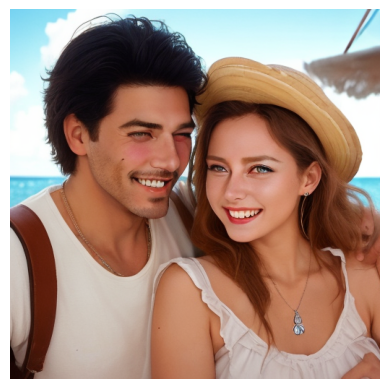

 67%|██████▋   | 41/61 [01:36<00:48,  2.41s/it]

t2i_similarity: 46.09375
character_similarity: 0.75634765625
face1 similarity: 0.6883202791213989
face2 similarity: 0.8522542715072632


 69%|██████▉   | 42/61 [01:38<00:45,  2.40s/it]

t2i_similarity: 45.8125
character_similarity: 0.748046875
face1 similarity: 0.7097762227058411
face2 similarity: 0.871300220489502


 70%|███████   | 43/61 [01:41<00:42,  2.38s/it]

t2i_similarity: 46.6875
character_similarity: 0.7421875
face1 similarity: 0.7322714924812317
face2 similarity: 0.8669350147247314


 72%|███████▏  | 44/61 [01:43<00:40,  2.37s/it]

t2i_similarity: 46.8125
character_similarity: 0.7607421875
face1 similarity: 0.7432280778884888
face2 similarity: 0.8738729953765869


 74%|███████▍  | 45/61 [01:45<00:37,  2.37s/it]

t2i_similarity: 46.9375
character_similarity: 0.765625
face1 similarity: 0.7523372173309326
face2 similarity: 0.8818728923797607


 75%|███████▌  | 46/61 [01:48<00:35,  2.37s/it]

t2i_similarity: 42.625
character_similarity: 0.765625
face1 similarity: 0.7522050738334656
face2 similarity: 0.8712085485458374


 77%|███████▋  | 47/61 [01:50<00:33,  2.37s/it]

t2i_similarity: 46.96875
character_similarity: 0.76025390625
face1 similarity: 0.7584062814712524
face2 similarity: 0.8560426235198975


 79%|███████▊  | 48/61 [01:53<00:30,  2.37s/it]

t2i_similarity: 46.5
character_similarity: 0.7626953125
face1 similarity: 0.750156044960022
face2 similarity: 0.857428789138794


 80%|████████  | 49/61 [01:55<00:28,  2.37s/it]

t2i_similarity: 47.0625
character_similarity: 0.7724609375
face1 similarity: 0.7654991745948792
face2 similarity: 0.8694115281105042


 82%|████████▏ | 50/61 [01:57<00:26,  2.37s/it]

t2i_similarity: 47.46875
character_similarity: 0.7822265625
face1 similarity: 0.757226824760437
face2 similarity: 0.8885197043418884
loss: 278.23785400390625
grad: [110.6875, 57.28125, 33.53125, 29.625]
time: 0.25852179527282715 0.1242678165435791 (0.500000) 0.6398086547851562 1.032271146774292 0.0018630027770996094


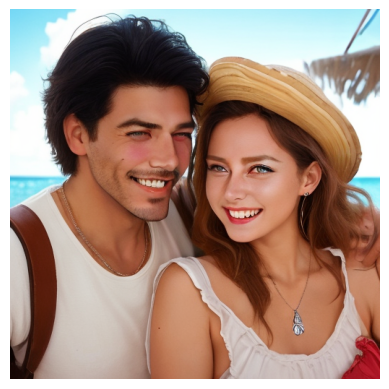

 84%|████████▎ | 51/61 [02:00<00:24,  2.40s/it]

t2i_similarity: 47.09375
character_similarity: 0.77734375
face1 similarity: 0.7597898840904236
face2 similarity: 0.8803870677947998


 85%|████████▌ | 52/61 [02:02<00:21,  2.40s/it]

t2i_similarity: 47.5625
character_similarity: 0.724609375
face1 similarity: 0.7900111675262451
face2 similarity: 0.8979587554931641


 87%|████████▋ | 53/61 [02:04<00:19,  2.39s/it]

t2i_similarity: 44.84375
character_similarity: 0.775390625
face1 similarity: 0.7978028059005737
face2 similarity: 0.8622097969055176


 89%|████████▊ | 54/61 [02:07<00:16,  2.37s/it]

t2i_similarity: 48.40625
character_similarity: 0.791015625
face1 similarity: 0.7890845537185669
face2 similarity: 0.8920526504516602


 90%|█████████ | 55/61 [02:09<00:14,  2.36s/it]

t2i_similarity: 48.25
character_similarity: 0.7275390625
face1 similarity: 0.7759060859680176
face2 similarity: 0.8906087875366211


 92%|█████████▏| 56/61 [02:11<00:11,  2.35s/it]

t2i_similarity: 48.03125
character_similarity: 0.75341796875
face1 similarity: 0.772472620010376
face2 similarity: 0.8967292308807373


 93%|█████████▎| 57/61 [02:14<00:09,  2.35s/it]

t2i_similarity: 48.4375
character_similarity: 0.7861328125
face1 similarity: 0.7989267110824585
face2 similarity: 0.8858979940414429


 95%|█████████▌| 58/61 [02:16<00:07,  2.35s/it]

t2i_similarity: 46.09375
character_similarity: 0.7900390625
face1 similarity: 0.7981604337692261
face2 similarity: 0.8998611569404602


 97%|█████████▋| 59/61 [02:19<00:04,  2.34s/it]

t2i_similarity: 49.0
character_similarity: 0.791015625
face1 similarity: 0.7718620300292969
face2 similarity: 0.9062783718109131


 98%|█████████▊| 60/61 [02:21<00:02,  2.35s/it]

t2i_similarity: 48.78125
character_similarity: 0.7998046875
face1 similarity: 0.8083927035331726
face2 similarity: 0.902094841003418
loss: 231.34823608398438
grad: [91.0625, 71.1875, 46.25, 40.1875]
time: 0.25913047790527344 0.12371420860290527 (0.500000) 0.649432897567749 1.0311269760131836 0.0011532306671142578


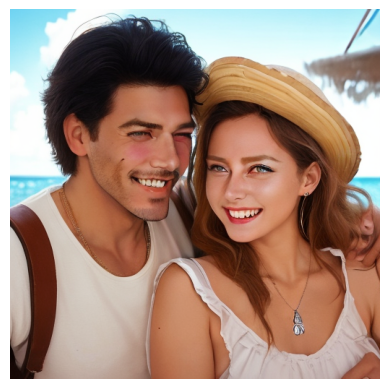

100%|██████████| 61/61 [02:23<00:00,  2.36s/it]


In [15]:
latents_last = latents.data.clone()
latents_last_e = latents.data.clone()
initialized_i = -1

def callback(self, i, t, callback_kwargs):
    global latents_last, latents_last_e, initialized_i
    if initialized_i < i:
        latents[i:(i+1)].data.copy_(callback_kwargs['latents'])
        latents_last[i:(i+1)].copy_(callback_kwargs['latents'])
        latents_last_e[i:(i+1)].copy_(callback_kwargs['latents'])
        initialized_i = i
    if i < 3:
        callback_kwargs['latents'] += latents[(i+1):(i+2)] - latents[(i+1):(i+2)].detach()
    latents_e = callback_kwargs['latents'].data.clone()
    callback_kwargs['latents'] += latents_last[i:(i+1)].detach() - callback_kwargs['latents'].detach()
    callback_kwargs['latents'] += latents_e.detach() - latents_last_e[i:(i+1)].detach()
    # callback_kwargs['latents'] += latents[i:(i+1)].detach() - latents_last_e[i:(i+1)].detach()
    callback_kwargs['latents'] += (latents[i:(i+1)].detach() - latents_last_e[i:(i+1)].detach()) * 0.95796674
    latents_last[i:(i+1)].copy_(callback_kwargs['latents'])
    latents_last_e[i:(i+1)].data.copy_(latents_e)
    latents[i:(i+1)].data.copy_(latents_e)
    return callback_kwargs

for epoch in tqdm(range(61)):
    t0 = time.time()
    image = my_forward(pipe, prompt=prompt, num_inference_steps=4, guidance_scale=3.0, latents=latents0+latents[:1]-latents[:1].detach(), output_type='pt', return_dict=False, callback_on_step_end=callback)[0][0]
    t1 = time.time()

    det_thresh_backup = detector.det_thresh
    boxes = []
    while len(boxes) <= 1:
        boxes, kpss = detector.detect(np.array(image.permute(1, 2, 0).detach().cpu().numpy() * 255, dtype=np.uint8), max_num=2)
        detector.det_thresh -= 0.1
    det_thresh_backup2 = detector.det_thresh + 0.1
    detector.det_thresh = det_thresh_backup
    t2 = time.time()

    M1 = insightface.utils.face_align.estimate_norm(kpss[0])
    image_cropped_1 = kornia.geometry.transform.warp_affine(
        image.float().unsqueeze(0), torch.tensor(M1).float().unsqueeze(0).to('cuda'), (112, 112)
    ) * 2 - 1
    M2 = insightface.utils.face_align.estimate_norm(kpss[1])
    image_cropped_2 = kornia.geometry.transform.warp_affine(
        image.float().unsqueeze(0), torch.tensor(M2).float().unsqueeze(0).to('cuda'), (112, 112)
    ) * 2 - 1
    embedding_1 = model(image_cropped_1)
    embedding_2 = model(image_cropped_2)
    ref_embeddings = torch.cat([ref_embedding1, ref_embedding2, ref_embedding1, ref_embedding2])
    t2i_similarity = text2img_similarity(clip_model,
                                        image=image,  
                                        caption='Close-up photo of the happy smiles on the faces of the cool man and beautiful woman as they leave the island with the treasure, sail back to the vacation beach, and begin their love story, 35mm photograph, film, professional, 4k, highly detailed.')


    print("t2i_similarity:", t2i_similarity.item())
    image_np = np.array(image.permute(1, 2, 0).detach().cpu().numpy() * 255, dtype=np.uint8)
    character_similarity = char2char_similarity(dino_model,
                                            clip_model,
                                            sam_predictor,
                                            processor=clip_processor,
                                            generate_image_np=image_np,
                                            generate_image=image,
                                            character_image_list_np=character_image_list_np,
                                            character_image_list=character_image_list,
                                            device='cuda')
    print("character_similarity:", character_similarity.item())
    proposal_embeddings = torch.cat([embedding_1, embedding_2, embedding_2, embedding_1])
    sim = F.cosine_similarity(ref_embeddings, proposal_embeddings)
    print("face1 similarity:", max(sim[0], sim[3]).item())
    print("face2 similarity:", max(sim[1], sim[2]).item())

    # loss = (50 - t2i_similarity) * 10+ (2 - max(sim[0] + sim[1], sim[2] + sim[3])) * 100 + (100 - character_similarity * 100) * 10

    if epoch >= 30 and max(sim[0], sim[3]).item() > 0.9:
       loss = (50 - t2i_similarity) * 10+ (1 - max(sim[1], sim[2])) * 100 + (100 - character_similarity * 100) * 10 
    elif epoch >= 30 and max(sim[1], sim[2]).item() > 0.9:
       loss = (50 - t2i_similarity) * 10+ (1 - max(sim[0], sim[3])) * 100 + (100 - character_similarity * 100) * 10 
    else:
       loss = (50 - t2i_similarity) * 10+ (2 - max(sim[0] + sim[1], sim[2] + sim[3])) * 100 + (100 - character_similarity * 100) * 10
    t3 = time.time()

    optimizer.zero_grad()
    loss.backward()
    t4 = time.time()
    grad_norm = latents.grad.reshape(4, -1).norm(dim=-1)
    latents.grad /= grad_norm.reshape(4, 1, 1, 1).clamp(min=1)
    # latents.grad.clamp_(min=-2e-2, max=2e-2)  # optional for removing artifacts
    optimizer.step()
    t5 = time.time()

    if epoch % 10 == 0:
        print('loss:', loss.data.item())
        print('grad:', grad_norm.tolist())
        print('time:', t1-t0, t2-t1, '(%f)' % det_thresh_backup2, t3-t2, t4-t3, t5-t4)
        plt.imshow(np.array(image.permute(1, 2, 0).detach().cpu() * 255, dtype=np.uint8))
        plt.axis("off")
        plt.show()
    # Convert the tensor to a NumPy array and scale it to 0-255
    image_np = np.array(image.permute(1, 2, 0).detach().cpu() * 255, dtype=np.uint8)

    # Create a PIL image
    image_pil = Image.fromarray(image_np)

    if not os.path.exists('./images'):
        os.makedirs('./images')
    # Save the image
    image_pil.save('./images/image_%d.png' % epoch)